In [11]:
import sys
sys.path.append('..')
from pathlib import Path
from skimage.metrics import structural_similarity as ssim
import numpy as np
from brisque import BRISQUE
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import shutil
import torch
import pandas as pd

# Image transformation for resizing original images
IMSIZE = 512 if torch.cuda.is_available() else 128
resize_loader = transforms.Compose([
    transforms.Resize(IMSIZE),  # Resize shorter side
    transforms.CenterCrop(IMSIZE)  # Crop to square
])

In [35]:
df = pd.read_csv("../data/tiny/dataset_balanced_nst/style_content_mapping.csv")

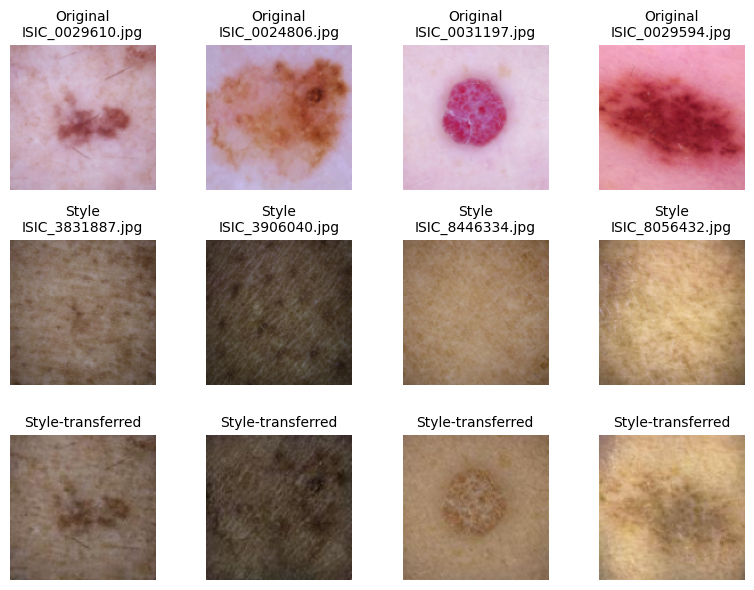

In [ ]:
def plot_sample_trios(df, num_to_show=3):
    """
    Plot random image trios (original above, style, generated below).
    """

    df = df.sample(n=num_to_show)
    
    fig, axes = plt.subplots(3, num_to_show, figsize=(2 * num_to_show, 6))

    for idx in range(num_to_show):
        original_path = Path(df["content_image"].iloc[idx])
        style_path = Path(df["style_image"].iloc[idx])
        generated_path = Path(df["generated_image"].iloc[idx])

        # Load images
        original_img = resize_loader(Image.open(original_path).convert("RGB"))
        style_img = resize_loader(Image.open(style_path).convert("RGB"))
        generated_img = Image.open(generated_path).convert("RGB")

        # Top row: original
        axes[0][idx].imshow(original_img)
        axes[0][idx].set_title(f"Original\n{original_path.name}", fontsize=10)
        axes[0][idx].axis("off")

        # Middle row: style
        axes[1][idx].imshow(style_img)
        axes[1][idx].set_title(f"Style\n{style_path.name}", fontsize=10)
        axes[1][idx].axis("off")

        # Bottom row: generated
        axes[2][idx].imshow(generated_img)
        axes[2][idx].set_title(f"Style-transferred", fontsize=10)
        axes[2][idx].axis("off")

    plt.tight_layout()
    plt.show()

plot_sample_trios(df, 4)

In [2]:
def calculate_ssim(original_image, generated_image, grayscale=False):
    """
    Calculate the Structural Similarity Index Measure (SSIM) between two images.
    
    SSIM evaluates the perceived quality of the generated image compared to the original
    by assessing structural information, luminance, and contrast. It's designed to
    better match human visual perception than simpler metrics like MSE or PSNR.
    
    The SSIM index ranges from -1 to 1, where:
    - 1 indicates perfect structural similarity (identical images)
    - 0 indicates no structural similarity
    - -1 would indicate perfect anti-correlation (rarely occurs in practice)
    
    Typical interpretation:
    - 0.90-1.00: Excellent similarity
    - 0.80-0.90: Good similarity
    - 0.70-0.80: Fair similarity
    - Below 0.70: Poor similarity
    
    Note: This implementation can handle both grayscale and RGB images.
    For RGB images, the function can either:
    1. Convert to grayscale (when grayscale=True - simpler but loses color information)
    2. Compute SSIM on full RGB (when grayscale=False - preserves color information)
    
    Args:
        original_image: The reference image (numpy array or PIL Image)
        generated_image: The image to compare against the reference (numpy array or PIL Image)
        grayscale: Whether to convert images to grayscale before comparison (default: True)
        
    Returns:
        float: SSIM score between the two images (higher is better)
    """
    
    # Convert tensor images to NumPy arrays
    original = np.array(original_image)
    generated = np.array(generated_image)

    # Convert to grayscale if specified
    if grayscale and original.ndim == 3 and original.shape[2] >= 3:
        # Use weighted conversion for better perceptual accuracy
        original = np.dot(original[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)
        generated = np.dot(generated[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)
        return ssim(original, generated, data_range=255)
    else:
        # Handle multichannel images
        if original.ndim == 3 and original.shape[2] >= 3:
            # For newer scikit-image versions
            try:
                return ssim(original, generated, data_range=255, channel_axis=2)
            # For older scikit-image versions
            except TypeError:
                return ssim(original, generated, data_range=255, multichannel=True)
        else:
            # For grayscale images
            return ssim(original, generated, data_range=255)

In [3]:
def calculate_brisque(generated_image):
    """
    Calculate the Blind/Referenceless Image Spatial Quality Evaluator (BRISQUE) score.
    
    BRISQUE is a no-reference image quality assessment algorithm that evaluates
    the naturalness of an image based on measured deviations from statistical
    regularities observed in natural images.
    
    Lower scores generally indicate better perceptual quality. The typical range
    is 0-100, where:
    - Scores around 0-30 indicate good quality images
    - Scores around 30-50 indicate medium quality
    - Scores above 50 may indicate lower quality or distorted images
    
    Note: BRISQUE requires the image to be in uint8 format (0-255 range) and
    works with both grayscale and color images. For color images, the score is
    typically calculated on the luminance (Y) channel.
    
    Args:
        generated_image: The input image to evaluate, can be PIL Image or numpy array
        
    Returns:
        float: The BRISQUE score (lower is better)
    """
    brisque = BRISQUE(url=False)
    return brisque.score(img=np.asarray(generated_image))

In [38]:
def get_scores(df):
    """
    Get the scores for each image in the DataFrame.
    
    Args:
        df: DataFrame containing paths to original and generated images
        
    Returns:
        dict: Updated DataFrame scores as new columns
    """

    for idx, row in df.iterrows():
        original_path = Path(row["content_image"])
        generated_path = Path(row["generated_image"])
        
        # Load images directly as PIL images (no tensor conversion)
        generated_image = Image.open(generated_path)
        original_image = resize_loader(Image.open(original_path))
        
        # Calculate metrics on PIL images
        df.loc[idx, "ssim_rgb"] = calculate_ssim(original_image, generated_image, grayscale=False)
        df.loc[idx, "ssim_gray"] = calculate_ssim(original_image, generated_image, grayscale=True)
        df.loc[idx, "brisque"] = calculate_brisque(generated_image)    
    
    return df

df = get_scores(df)

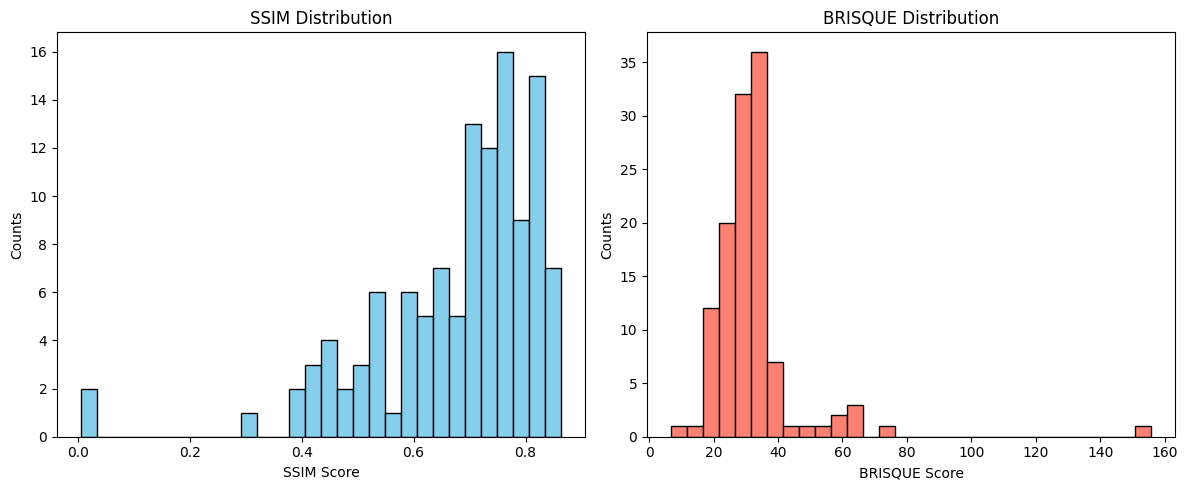

In [39]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# SSIM distribution
axes[0].hist(df['ssim_rgb'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title("SSIM Distribution")
axes[0].set_xlabel("SSIM Score")
axes[0].set_ylabel("Counts")

# BRISQUE distribution
axes[1].hist(df['brisque'], bins=30, color='salmon', edgecolor='black')
axes[1].set_title("BRISQUE Distribution")
axes[1].set_xlabel("BRISQUE Score")
axes[1].set_ylabel("Counts")

plt.tight_layout()
plt.show()

In [43]:
def plot_score_extremes(df, score_type="ssim", num_to_show=3):
    """
    Plot image pairs (original above, generated below) for low, median, and high scores.

    Args:
        nst_scores (dict): Dictionary containing image paths and scores.
        score_type (str): "ssim" or "brisque"
        num_to_show (int): Number of image pairs to display horizontally
    """

    # Make a copy of the dataframe and sort by the score
    sorted_df = df.sort_values(by=score_type).reset_index()

    if num_to_show == 3:
        indices = [0, len(sorted_df) // 2, len(sorted_df) - 1]  # min, median, max
    elif num_to_show == 4:
        indices = [0, 1, len(sorted_df) - 2, len(sorted_df) - 1]  # min, 2nd min, 2nd max, max
    else:
        indices = np.linspace(0, len(sorted_df) - 1, num_to_show, dtype=int)  # n evenly spaced

    fig, axes = plt.subplots(2, num_to_show, figsize=(4 * num_to_show, 6))

    for idx, df_idx in enumerate(indices):
        row = sorted_df.iloc[df_idx]
        original_path = Path(row["content_image"])
        generated_path = Path(row["generated_image"])
        score = row[score_type]

        # Load images
        original_img = resize_loader(Image.open(original_path).convert("RGB"))
        generated_img = Image.open(generated_path).convert("RGB")

        # Top row: original
        axes[0][idx].imshow(original_img)
        axes[0][idx].set_title(f"Original\n{original_path.name}", fontsize=10)
        axes[0][idx].axis("off")

        # Bottom row: generated
        axes[1][idx].imshow(generated_img)
        axes[1][idx].set_title(f"Generated\n{generated_path.name}\n{score_type.upper()}: {score:.3f}", fontsize=10)
        axes[1][idx].axis("off")

    plt.tight_layout()
    plt.show()



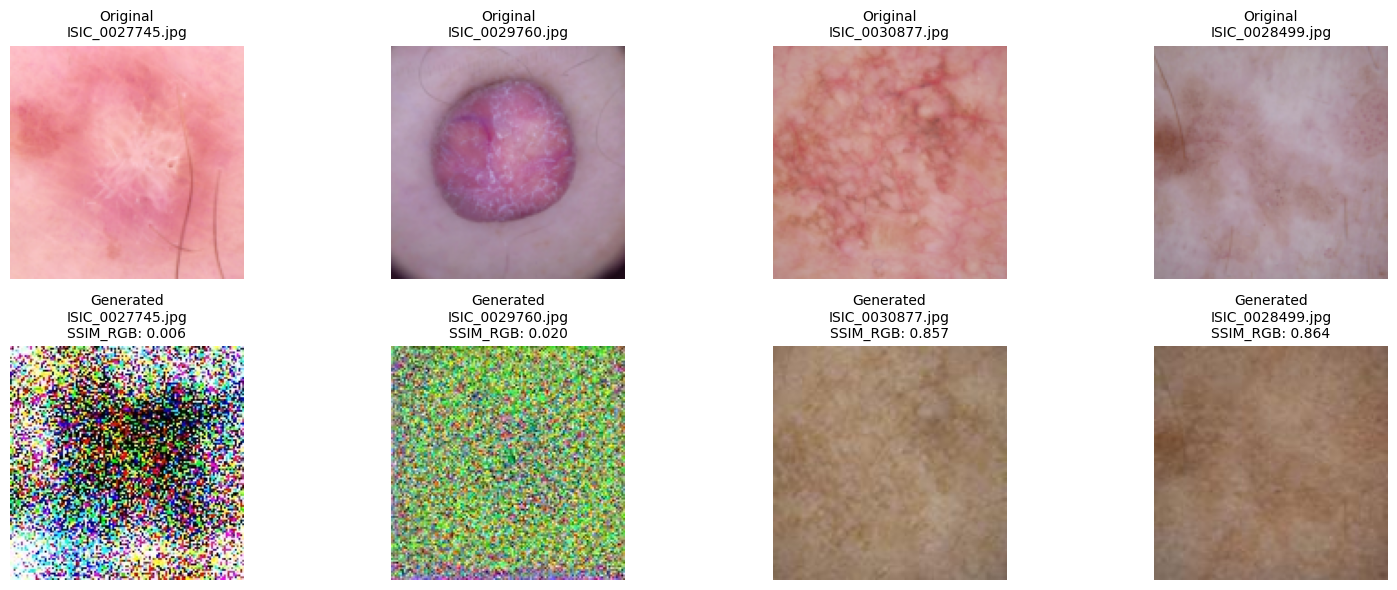

In [44]:
plot_score_extremes(df, score_type="ssim_rgb", num_to_show=4)

In [ ]:
def move_low_ssim_images(df, threshold=0.4):
    """
    Moves images with SSIM RGB scores below a threshold to a new directory.
    Creates an automatic output directory by appending "_excluded" to the original source directory.
    Preserves the original folder structure.
    
    Args:
        nst_scores (dict): Dictionary of scores containing SSIM values
        threshold (float): SSIM threshold value (images below this will be moved)
    """
    # Track statistics
    total_images = df.shape[0]
    moved_images = 0
    
    print(f"Moving images with SSIM RGB scores below {threshold}...")
    
    # Process each image in the scores dictionary
    for row in df.itertuples():
        # Check if the SSIM score is below threshold
        if row["ssim_rgb"] < threshold:
            # Get path of the generated image
            gen_path = Path(row["generated_image"])
            
            # Create output directory by appending "_excluded" to the source directory name
            source_parent_dir = gen_path.parent.parent
            output_parent_dir = Path(str(source_parent_dir) + "_excluded")
            
            # Get the class directory (i.e., the last part of the path)
            class_dir = gen_path.parent.name
            
            # Create the corresponding output directory
            target_dir = output_parent_dir / class_dir
            target_dir.mkdir(parents=True, exist_ok=True)
            
            # Target path for the moved file
            target_path = target_dir / gen_path.name
            
            try:
                # Move the file
                shutil.move(gen_path, target_path)
                moved_images += 1
                print(f"Moved {gen_path} to {target_path}")  # Log individual moves
            except Exception as e:
                print(f"Error moving {gen_path}: {str(e)}")
    
    print(f"Moved {moved_images} out of {total_images} images with SSIM RGB scores below {threshold}")
    return moved_images

move_low_ssim_images(df, threshold=0.4)

Moving images with SSIM RGB scores below 0.4...


  0%|          | 0/119 [00:00<?, ?it/s]

Moved /home/matthias/projects/all-skin-deep/data/tiny/dataset_balanced_nst/df/ISIC_0029760.jpg to /home/matthias/projects/all-skin-deep/data/tiny/dataset_balanced_nst_excluded/df/ISIC_0029760.jpg
Moved /home/matthias/projects/all-skin-deep/data/tiny/dataset_balanced_nst/df/ISIC_0027745.jpg to /home/matthias/projects/all-skin-deep/data/tiny/dataset_balanced_nst_excluded/df/ISIC_0027745.jpg
Moved /home/matthias/projects/all-skin-deep/data/tiny/dataset_balanced_nst/vasc/ISIC_0026068.jpg to /home/matthias/projects/all-skin-deep/data/tiny/dataset_balanced_nst_excluded/vasc/ISIC_0026068.jpg
Moved /home/matthias/projects/all-skin-deep/data/tiny/dataset_balanced_nst/vasc/ISIC_0026336.jpg to /home/matthias/projects/all-skin-deep/data/tiny/dataset_balanced_nst_excluded/vasc/ISIC_0026336.jpg
Moved 4 out of 119 images with SSIM RGB scores below 0.4
Skipped 0 files that were not found


4